# 1. Data Exploration

## Overview 
In the first section we will look at techniques to load and explore the data to be used for machine learning. The purpose of this exploration is to gain an understanding of the data and how it relates to the problem we are trying to solve. This will help us make sensible choices for different elements of our machine learning pipeline.

### Prerequisites 

To be able to successfully work through this notebook, you will need some understanding of the following 
* The Python programming language
* Simple data handling in Python
* Basic plotting using matplotlib
* Environment setup using pip or conda

### Learning Outcomes 

* Load tabular and gridded datasets using common python libraries.
* Explore typical techniques for *exploratory data analysis* on different sorts of data.
* Understand key characteristics of datasets to use in choosing components for a machine learning pipeline.

## Tutorial - Exploratory Data Analysis

The first step in a machine learning problem is to understand the available data you have for training a machine learning algorithm. In any data driven technique, the quality of the result is only going to be as good as the quality of the data. This can only be achieved by matching the appropriate techniques to the data that you have, so understanding the particular dataset to be used is the foundation of a successful outcome.

To achieve this, one typically performs an *Exploratory Data Analysis*, where one produce a series of summary statistics and plots that highlight the most salient characteristics of the dataset for the problem at hand. Typical traits to be considered include:
* The range of values for different input features e.g. min and max temperature, start and end dates.
* Important subsets of the data e.g. different seasons or time of the day.
* Distributions of different features, both as a whole and important subsets.
* Correlations between different features, especially input and target features.


### Best Practices & Values

Performing a thorough data exploration implements the Met Office Machine Learning best practices in the following ways:
* Ethics - Ensure we can justify our choices from understanding of the data and how the choices relates to the potential impacts of this work.
* Data - Ensure we understand biases or other issues with the data.
* ML Pitfall - Avoid pitfalls through making informed choices based on analysis of data.
* ML Lifecycle - Ensure we store and process the data so we can reproduce the results.

(Please see [Met Office Best Prctice Summary document](https://metoffice.sharepoint.com/:w:/r/sites/MetOfficeDataScienceCommunity/Shared%20Documents/MLAG/project_evaluation_review/MachineLearningBestPracticesAndValues_v1_0.docx?d=wae2554217d0342f2a9c8cf8906bfbe38&csf=1&web=1&e=ja7rLn) on Data Science Community site (internal only) for more information and further reading.)

## Exercise 1: Load and explore tabular dataset - Falkland Islands Airfield Rotors

The first dataset we will explore comes from a challenge by Operational Meteorologist Steve Ramsdale, around forecasting localised topographically-driven turbulent wind gusts at the Mount Pleasant Airfield in the Falkland Islands, which occur through northerly winds interacting with mountains to the north of the airfield. The aim is to predict whether or not these will occur, using data from global, coarse-resolution models which are not able to to explicitly resolve this phenomenon. 

The target is a human-created dataset produced by Operational Meteorologists at the airfield, as to whether a rotor occurred in any given three hour period.

In [1]:
import pathlib 
import datetime
import os
import functools

In [2]:
print('hello world!')

hello world!


In [3]:
import matplotlib
%matplotlib inline

In [4]:
import pandas

In [5]:
import iris
import iris.quickplot
import iris.coord_categorisation
import cartopy


In [6]:
import sklearn
import sklearn.metrics

In [7]:
try:
    falklands_data_dir = os.environ['OPMET_ROTORS_DATA_ROOT']
except KeyError:
    falklands_data_dir = '/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge'
falklands_data_dir = pathlib.Path(falklands_data_dir) /  'Rotors'
print(falklands_data_dir)

/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge/Rotors


In [8]:
falklands_data_fname = 'new_training.csv'

In [9]:
falklands_data_path = falklands_data_dir / falklands_data_fname
falklands_data_path

PosixPath('/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge/Rotors/new_training.csv')

In [10]:
falklands_data_path.is_file()

True

In [11]:
falklands_df = pandas.read_csv(falklands_data_path)

In [12]:
falklands_df

,DTG,air_temp_obs,dewpoint_obs,wind_direction_obs,wind_speed_obs,wind_gust_obs,air_temp_1,air_temp_2,air_temp_3,air_temp_4,...,windspd_18,winddir_19,windspd_19,winddir_20,windspd_20,winddir_21,windspd_21,winddir_22,windspd_22,Rotors 1 is true
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01/01/2015 00:00,283.9,280.7,110.0,4.1,-9999999.0,284.000,283.625,283.250,282.625,...,5.8,341.0,6.0,334.0,6.1,330.0,6.0,329.0,5.8,NaN
2,01/01/2015 03:00,280.7,279.7,90.0,7.7,-9999999.0,281.500,281.250,280.750,280.250,...,6.8,344.0,5.3,348.0,3.8,360.0,3.2,12.0,3.5,NaN
3,01/01/2015 06:00,279.8,278.1,100.0,7.7,-9999999.0,279.875,279.625,279.125,278.625,...,6.0,345.0,5.5,358.0,5.0,10.0,4.2,38.0,4.0,NaN
4,01/01/2015 09:00,279.9,277.0,120.0,7.2,-9999999.0,279.625,279.250,278.875,278.250,...,3.1,338.0,3.5,354.0,3.9,9.0,4.4,22.0,4.6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101,31/12/2020 06:00,276.7,275.5,270.0,3.6,-9999999.0,277.875,277.750,277.625,277.500,...,12.1,223.0,11.8,221.0,11.4,219.0,11.3,215.0,11.4,NaN
20102,31/12/2020 09:00,277.9,276.9,270.0,3.1,-9999999.0,277.875,277.625,277.875,277.875,...,10.2,230.0,10.8,230.0,11.6,227.0,12.3,222.0,12.0,NaN
20103,31/12/2020 12:00,283.5,277.1,220.0,3.6,-9999999.0,281.125,280.625,280.125,279.625,...,10.3,218.0,11.9,221.0,12.8,222.0,11.9,225.0,10.6,NaN
20104,31/12/2020 15:00,286.1,276.9,250.0,3.6,-9999999.0,284.625,284.125,283.625,283.000,...,9.4,218.0,8.6,212.0,8.3,218.0,8.7,226.0,10.1,NaN


In [13]:
falklands_df.columns

Index(['DTG', 'air_temp_obs', 'dewpoint_obs', 'wind_direction_obs',
       'wind_speed_obs', 'wind_gust_obs', 'air_temp_1', 'air_temp_2',
       'air_temp_3', 'air_temp_4', 'air_temp_5', 'air_temp_6', 'air_temp_7',
       'air_temp_8', 'air_temp_9', 'air_temp_10', 'air_temp_11', 'air_temp_12',
       'air_temp_13', 'air_temp_14', 'air_temp_15', 'air_temp_16',
       'air_temp_17', 'air_temp_18', 'air_temp_19', 'air_temp_20',
       'air_temp_21', 'air_temp_22', 'sh_1', 'sh_2', 'sh_3', 'sh_4', 'sh_5',
       'sh_6', 'sh_7', 'sh_8', 'sh_9', 'sh_10', 'sh_11', 'sh_12', 'sh_13',
       'sh_14', 'sh_15', 'sh_16', 'sh_17', 'sh_18', 'sh_19', 'sh_20', 'sh_21',
       'sh_22', 'winddir_1', 'windspd_1', 'winddir_2', 'windspd_2',
       'winddir_3', 'windspd_3', 'winddir_4', 'windspd_4', 'winddir_5',
       'windspd_5', 'winddir_6', 'windspd_6', 'winddir_7', 'windspd_7',
       'winddir_8', 'windspd_8', 'winddir_9', 'windspd_9', 'winddir_10',
       'windspd_10', 'winddir_11', 'windspd_11', 'windd

We perform some initial cleaning of the dataset to make it easier to work with. Ideally this could be done once and saved out for future use.

In [14]:
# rename target variable
falklands_df = falklands_df.rename({'Rotors 1 is true': 'rotors'},axis=1)

# set missing values to 0
falklands_df.loc[falklands_df[falklands_df['rotors'].isna()].index, 'rotors'] = 0

# Create date and times
falklands_df['DTG'] = pandas.to_datetime(falklands_df['DTG'])

# Drop duplicate dates and times
falklands_df = falklands_df.drop_duplicates(subset=['DTG'])

# remove observations with no dates and times
falklands_df = falklands_df[~falklands_df['DTG'].isnull()]

# subset observation so that wind speed, air temp, wind direction and dewpoints
# are all greater than 0  (temperatures are in kevlen
falklands_df = falklands_df[(falklands_df['wind_speed_obs'] >= 0.0) &
                            (falklands_df['air_temp_obs'] >= 0.0) &
                            (falklands_df['wind_direction_obs'] >= 0.0) &
                            (falklands_df['dewpoint_obs'] >= 0.0) 
                           ]
falklands_df

,DTG,air_temp_obs,dewpoint_obs,wind_direction_obs,wind_speed_obs,wind_gust_obs,air_temp_1,air_temp_2,air_temp_3,air_temp_4,...,windspd_18,winddir_19,windspd_19,winddir_20,windspd_20,winddir_21,windspd_21,winddir_22,windspd_22,rotors
1,2015-01-01 00:00:00,283.9,280.7,110.0,4.1,-9999999.0,284.000,283.625,283.250,282.625,...,5.8,341.0,6.0,334.0,6.1,330.0,6.0,329.0,5.8,0.0
2,2015-01-01 03:00:00,280.7,279.7,90.0,7.7,-9999999.0,281.500,281.250,280.750,280.250,...,6.8,344.0,5.3,348.0,3.8,360.0,3.2,12.0,3.5,0.0
3,2015-01-01 06:00:00,279.8,278.1,100.0,7.7,-9999999.0,279.875,279.625,279.125,278.625,...,6.0,345.0,5.5,358.0,5.0,10.0,4.2,38.0,4.0,0.0
4,2015-01-01 09:00:00,279.9,277.0,120.0,7.2,-9999999.0,279.625,279.250,278.875,278.250,...,3.1,338.0,3.5,354.0,3.9,9.0,4.4,22.0,4.6,0.0
5,2015-01-01 12:00:00,279.9,277.4,120.0,8.7,-9999999.0,279.250,278.875,278.375,277.875,...,1.6,273.0,2.0,303.0,2.3,329.0,2.5,338.0,2.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101,2020-12-31 06:00:00,276.7,275.5,270.0,3.6,-9999999.0,277.875,277.750,277.625,277.500,...,12.1,223.0,11.8,221.0,11.4,219.0,11.3,215.0,11.4,0.0
20102,2020-12-31 09:00:00,277.9,276.9,270.0,3.1,-9999999.0,277.875,277.625,277.875,277.875,...,10.2,230.0,10.8,230.0,11.6,227.0,12.3,222.0,12.0,0.0
20103,2020-12-31 12:00:00,283.5,277.1,220.0,3.6,-9999999.0,281.125,280.625,280.125,279.625,...,10.3,218.0,11.9,221.0,12.8,222.0,11.9,225.0,10.6,0.0
20104,2020-12-31 15:00:00,286.1,276.9,250.0,3.6,-9999999.0,284.625,284.125,283.625,283.000,...,9.4,218.0,8.6,212.0,8.3,218.0,8.7,226.0,10.1,0.0


Our target variables is the *rotors* column, labelling whether or not one or more rotors occurred in a given 3 hour period.

In [17]:
# Frequency table of events

falklands_df['rotors'].value_counts()

0.0    17037
1.0      449
Name: rotors, dtype: int64

We see that this is an *imbalanced* classification problem. As a result we will have to consider carefully how to take this into account in our ML pipeline. This is because if we don't <mark> the classifier will get a good score by never predicting rotors, </mark> in this particular problem an accuracy of greater than 97% is achieved by this approach.  This is of course not a useful result for this problem based on what we want to achieve. Some of the ways we can take the class imbalance into account include:
* *train/test split* - Ensure the distribution between classes in the train, validation and test sets is close to the distribution for the whole dataset, and also that this distribution is representative of the real-world problem.
* *possible resampling strategies* - One can resample/undersample/oversample training data so the algorithm is presented with balanced training data
* *classification metrics* - Ensure that the metric represents the *business need* and *actual costs* of making one prediction or another. In this, failing to predict a rotor event that occurs is very costly and should be penalised by the metric we use, where as predicting a rotor event that does not occur (false positive) is still ndesriable, but less costly so should be less penalised by our algorithm.

In [18]:
falklands_df.columns

Index(['DTG', 'air_temp_obs', 'dewpoint_obs', 'wind_direction_obs',
       'wind_speed_obs', 'wind_gust_obs', 'air_temp_1', 'air_temp_2',
       'air_temp_3', 'air_temp_4', 'air_temp_5', 'air_temp_6', 'air_temp_7',
       'air_temp_8', 'air_temp_9', 'air_temp_10', 'air_temp_11', 'air_temp_12',
       'air_temp_13', 'air_temp_14', 'air_temp_15', 'air_temp_16',
       'air_temp_17', 'air_temp_18', 'air_temp_19', 'air_temp_20',
       'air_temp_21', 'air_temp_22', 'sh_1', 'sh_2', 'sh_3', 'sh_4', 'sh_5',
       'sh_6', 'sh_7', 'sh_8', 'sh_9', 'sh_10', 'sh_11', 'sh_12', 'sh_13',
       'sh_14', 'sh_15', 'sh_16', 'sh_17', 'sh_18', 'sh_19', 'sh_20', 'sh_21',
       'sh_22', 'winddir_1', 'windspd_1', 'winddir_2', 'windspd_2',
       'winddir_3', 'windspd_3', 'winddir_4', 'windspd_4', 'winddir_5',
       'windspd_5', 'winddir_6', 'windspd_6', 'winddir_7', 'windspd_7',
       'winddir_8', 'windspd_8', 'winddir_9', 'windspd_9', 'winddir_10',
       'windspd_10', 'winddir_11', 'windspd_11', 'windd

Above we see the forecast variables from the Met Office Global Forecast model, which we want to use an input to our algorithm. We see there are 4 variables, each on 22 height levels, including
* temperature
* specific humidity
* wind speed
* wind direction

Next we split the data into two groups, to see how the distribution of input variables differs for samples with and without rotors.

In [15]:
# create a rotors and no rotors dataframe
no_rotors_df = falklands_df[falklands_df['rotors'] ==False]
rotors_present_df = falklands_df[falklands_df['rotors'] == True]

In [16]:
no_rotors_df.shape

(17037, 95)

In [17]:
rotors_present_df.shape

(449, 95)

17037 events where a rotor isn't present, 449 rotor events

We start by looking at the surface observations

/var/tmp/ipykernel_56830/1275007709.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


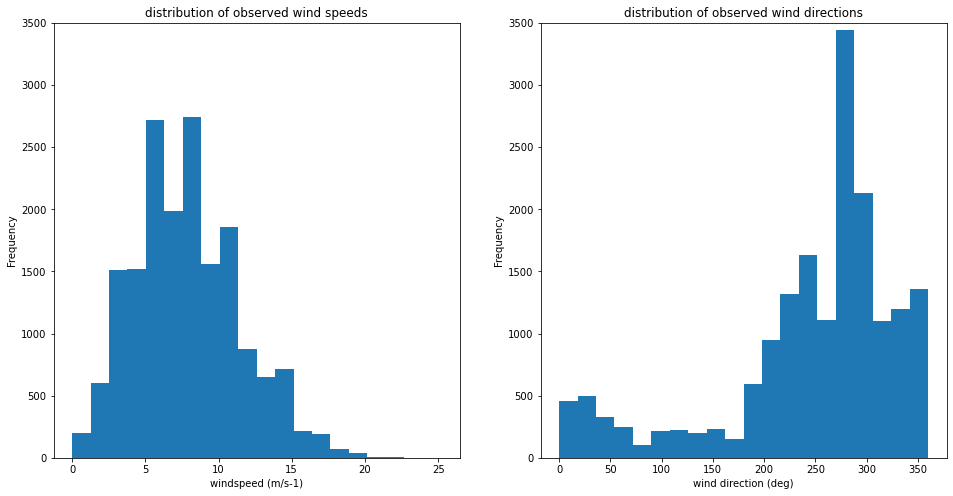

In [18]:
# Create figures
fig1 = matplotlib.pyplot.figure('distribution_wind_spevalue_countsirection', 
                                figsize=(16,8))

ax1 = fig1.add_subplot(1,2,1,title='distribution of observed wind speeds')

# In the first plot create histogram of wind speed with 20 bins
falklands_df['wind_speed_obs'].plot.hist(ax=ax1,bins=20)
ax1.set_xlabel('windspeed (m/s-1)',)  # x-label
ax1.set_ylim((0,3500))      # y-limits

# second plot
ax1 = fig1.add_subplot(1,2,2,title='distribution of observed wind directions')
falklands_df['wind_direction_obs'].plot.hist(ax=ax1,bins=20)
ax1.set_xlabel('wind direction (deg)',)
ax1.set_ylim((0,3500))
fig1.show()

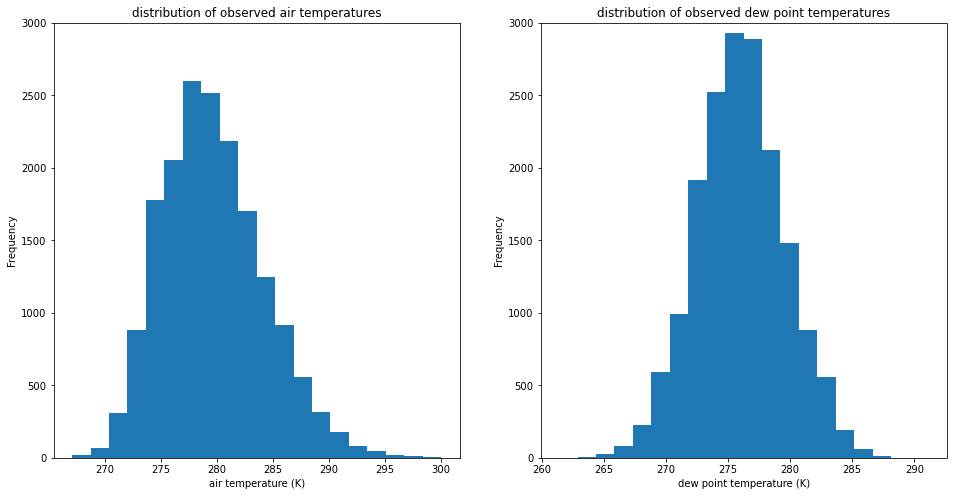

In [23]:
fig1 = matplotlib.pyplot.figure('distribution_temp_dewpoint', figsize=(16,8))
ax1 = fig1.add_subplot(1,2,1,title='distribution of observed air temperatures')
falklands_df['air_temp_obs'].plot.hist(ax=ax1,bins=20)
ax1.set_xlabel('air temperature (K)',)
ax1.set_ylim((0,3000))
ax1 = fig1.add_subplot(1,2,2,title='distribution of observed dew point temperatures')
falklands_df['dewpoint_obs'].plot.hist(ax=ax1,bins=20)
ax1.set_xlabel('dew point temperature (K)',)
ax1.set_ylim((0,3000))
fig1.show()

Now compare for rotors present/absent

['air_temp_obs', 'dewpoint_obs', 'wind_direction_obs', 'wind_speed_obs']


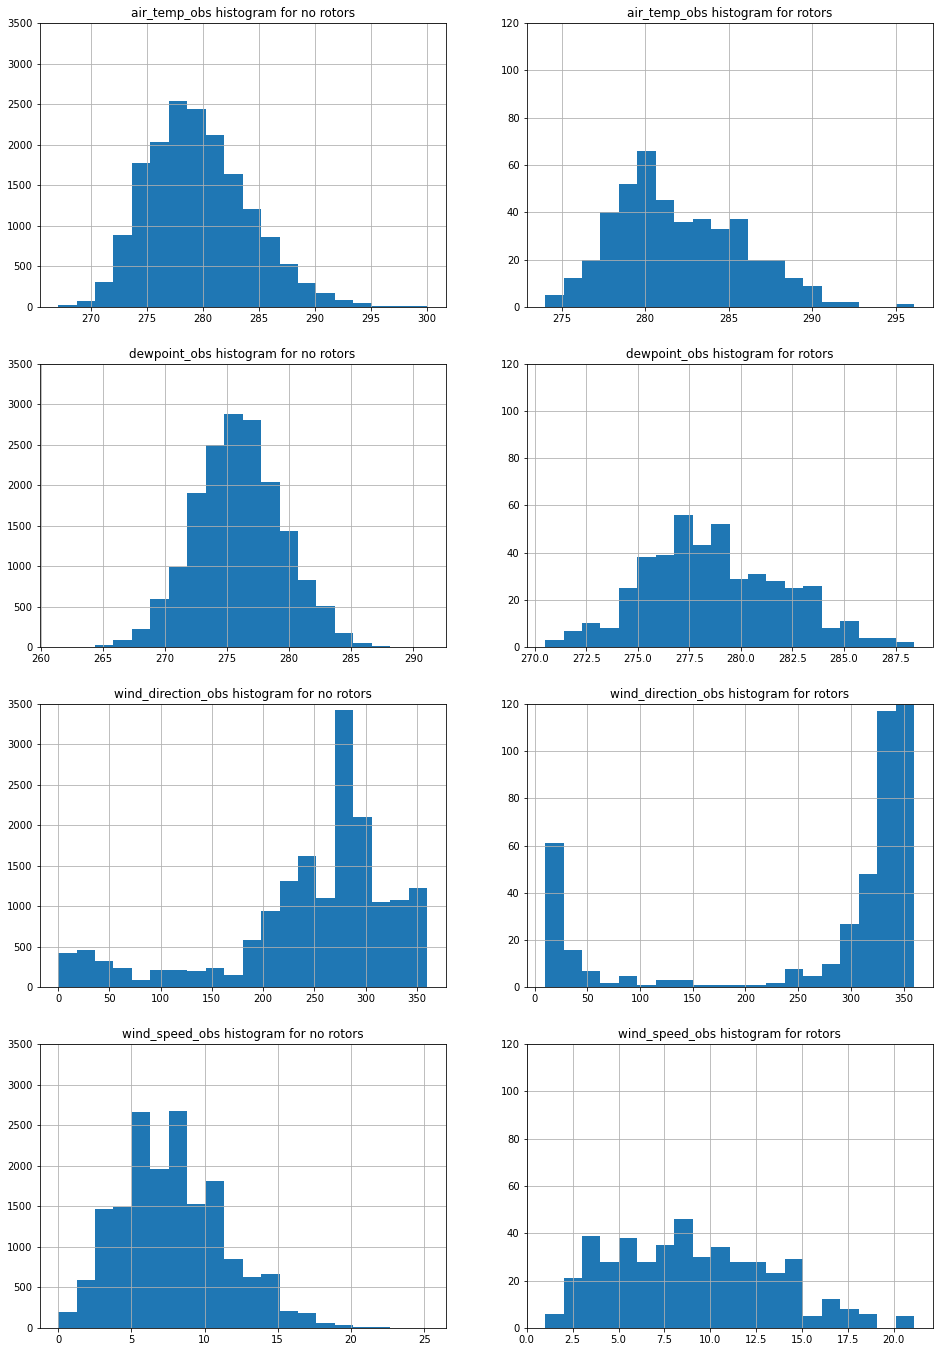

In [24]:
# List of variables that we want to plot

vars_to_plot = ['air_temp_obs', 'dewpoint_obs', 'wind_direction_obs', 'wind_speed_obs',]
print(vars_to_plot)

# Create plots
fig1 = matplotlib.pyplot.figure('comparing rota events',
                                figsize=(16,6*len(vars_to_plot)))
for ix1, var_name in enumerate(vars_to_plot):
    ax1 = fig1.add_subplot(len(vars_to_plot),2,ix1*2+1, 
                           title=f'{var_name} histogram for no rotors')

    # no rotors plot
    no_rotors_df[var_name].hist(bins=20,ax=ax1)
    ax1.set_ylim((0,3500))
    ax1 = fig1.add_subplot(len(vars_to_plot),2,ix1*2+2, 
                           title=f'{var_name} histogram for rotors')

    # Rotor plots
    rotors_present_df[var_name].hist(bins=20,ax=ax1)
    ax1.set_ylim((0,120))
fig1.show()

The above diagrams already show some differences for conditions at the surface when a rotor is observed compared to when it is not. <Mark> Most obvious is the wind direction </mark>, where rotors are found mostly in northerly winds, as is already known. Other surface variables show smaller differences.

We might also be interested in the link between occurrence frequency at different times of day or in different seasons. The plots below show a small peak in the middle of the day (which may due to observation bias), but no other obviously exploitable patterns in the data.

/var/tmp/ipykernel_56830/3779024728.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


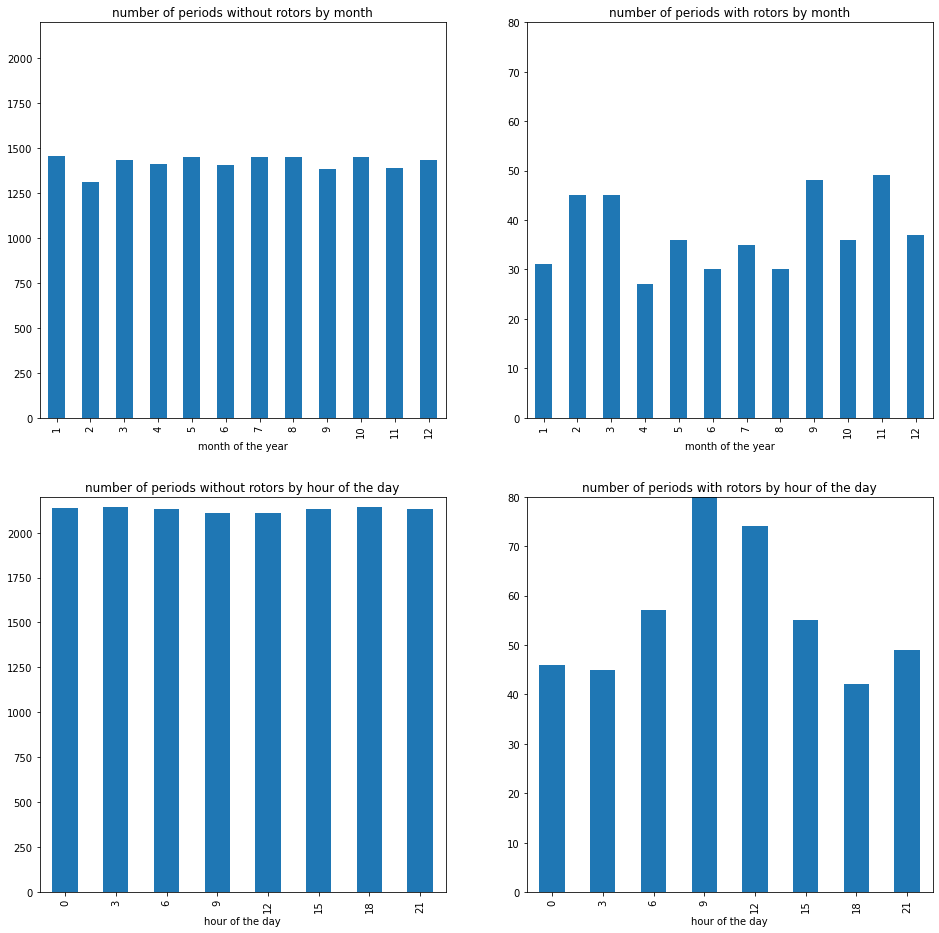

In [21]:
fig1 = matplotlib.pyplot.figure('time of year',figsize=(16,16))

# Monthly plots - no rotors
ax1 = fig1.add_subplot(2,2,1, title='number of periods without rotors by month')
# lambda function converst data to month - then a count of months is applied
no_rotors_df.groupby([ no_rotors_df['DTG'].apply(lambda x: x.month)])['DTG'].count().plot.bar( ax=ax1)
ax1.set_xlabel('month of the year')
ax1.set_ylim((0,2200))

# Monthly plots - rotors
ax1 = fig1.add_subplot(2,2,2, title='number of periods with rotors by month') 
rotors_present_df.groupby([ rotors_present_df['DTG'].apply(lambda x: x.month)])['DTG'].count().plot.bar(ax=ax1)
ax1.set_xlabel('month of the year')
ax1.set_ylim((0,80))

# Hour of the day plots - no rotors
ax1 = fig1.add_subplot(2,2,3, title='number of periods without rotors by hour of the day') 
no_rotors_df.groupby([ no_rotors_df['DTG'].apply(lambda x: x.hour)])['DTG'].count().plot.bar( ax=ax1)
ax1.set_xlabel('hour of the day')
ax1.set_ylim((0,2200))

# Hour of the day plots - with rotors
ax1 = fig1.add_subplot(2,2,4, title='number of periods with rotors by hour of the day') 
rotors_present_df.groupby([ rotors_present_df['DTG'].apply(lambda x: x.hour)])['DTG'].count().plot.bar(ax=ax1)
ax1.set_xlabel('hour of the day')
ax1.set_ylim((0,80))

fig1.show()

In [22]:
falklands_df.columns

Index(['DTG', 'air_temp_obs', 'dewpoint_obs', 'wind_direction_obs',
       'wind_speed_obs', 'wind_gust_obs', 'air_temp_1', 'air_temp_2',
       'air_temp_3', 'air_temp_4', 'air_temp_5', 'air_temp_6', 'air_temp_7',
       'air_temp_8', 'air_temp_9', 'air_temp_10', 'air_temp_11', 'air_temp_12',
       'air_temp_13', 'air_temp_14', 'air_temp_15', 'air_temp_16',
       'air_temp_17', 'air_temp_18', 'air_temp_19', 'air_temp_20',
       'air_temp_21', 'air_temp_22', 'sh_1', 'sh_2', 'sh_3', 'sh_4', 'sh_5',
       'sh_6', 'sh_7', 'sh_8', 'sh_9', 'sh_10', 'sh_11', 'sh_12', 'sh_13',
       'sh_14', 'sh_15', 'sh_16', 'sh_17', 'sh_18', 'sh_19', 'sh_20', 'sh_21',
       'sh_22', 'winddir_1', 'windspd_1', 'winddir_2', 'windspd_2',
       'winddir_3', 'windspd_3', 'winddir_4', 'windspd_4', 'winddir_5',
       'windspd_5', 'winddir_6', 'windspd_6', 'winddir_7', 'windspd_7',
       'winddir_8', 'windspd_8', 'winddir_9', 'windspd_9', 'winddir_10',
       'windspd_10', 'winddir_11', 'windspd_11', 'windd

In [23]:
# Create a dictionary for the model data by variable type

features_dict = {
    'air_temp': [c1 for c1 in falklands_df.columns if 'air_temp' in c1 and 'obs' not in c1],
    'dewpoint': [c1 for c1 in falklands_df.columns if 'sh' in c1 and 'obs' not in c1],
    'wind_speed': [c1 for c1 in falklands_df.columns if 'windspd' in c1 and 'obs' not in c1],
    'wind_dir': [c1 for c1 in falklands_df.columns if 'winddir' in c1 and 'obs' not in c1],
}

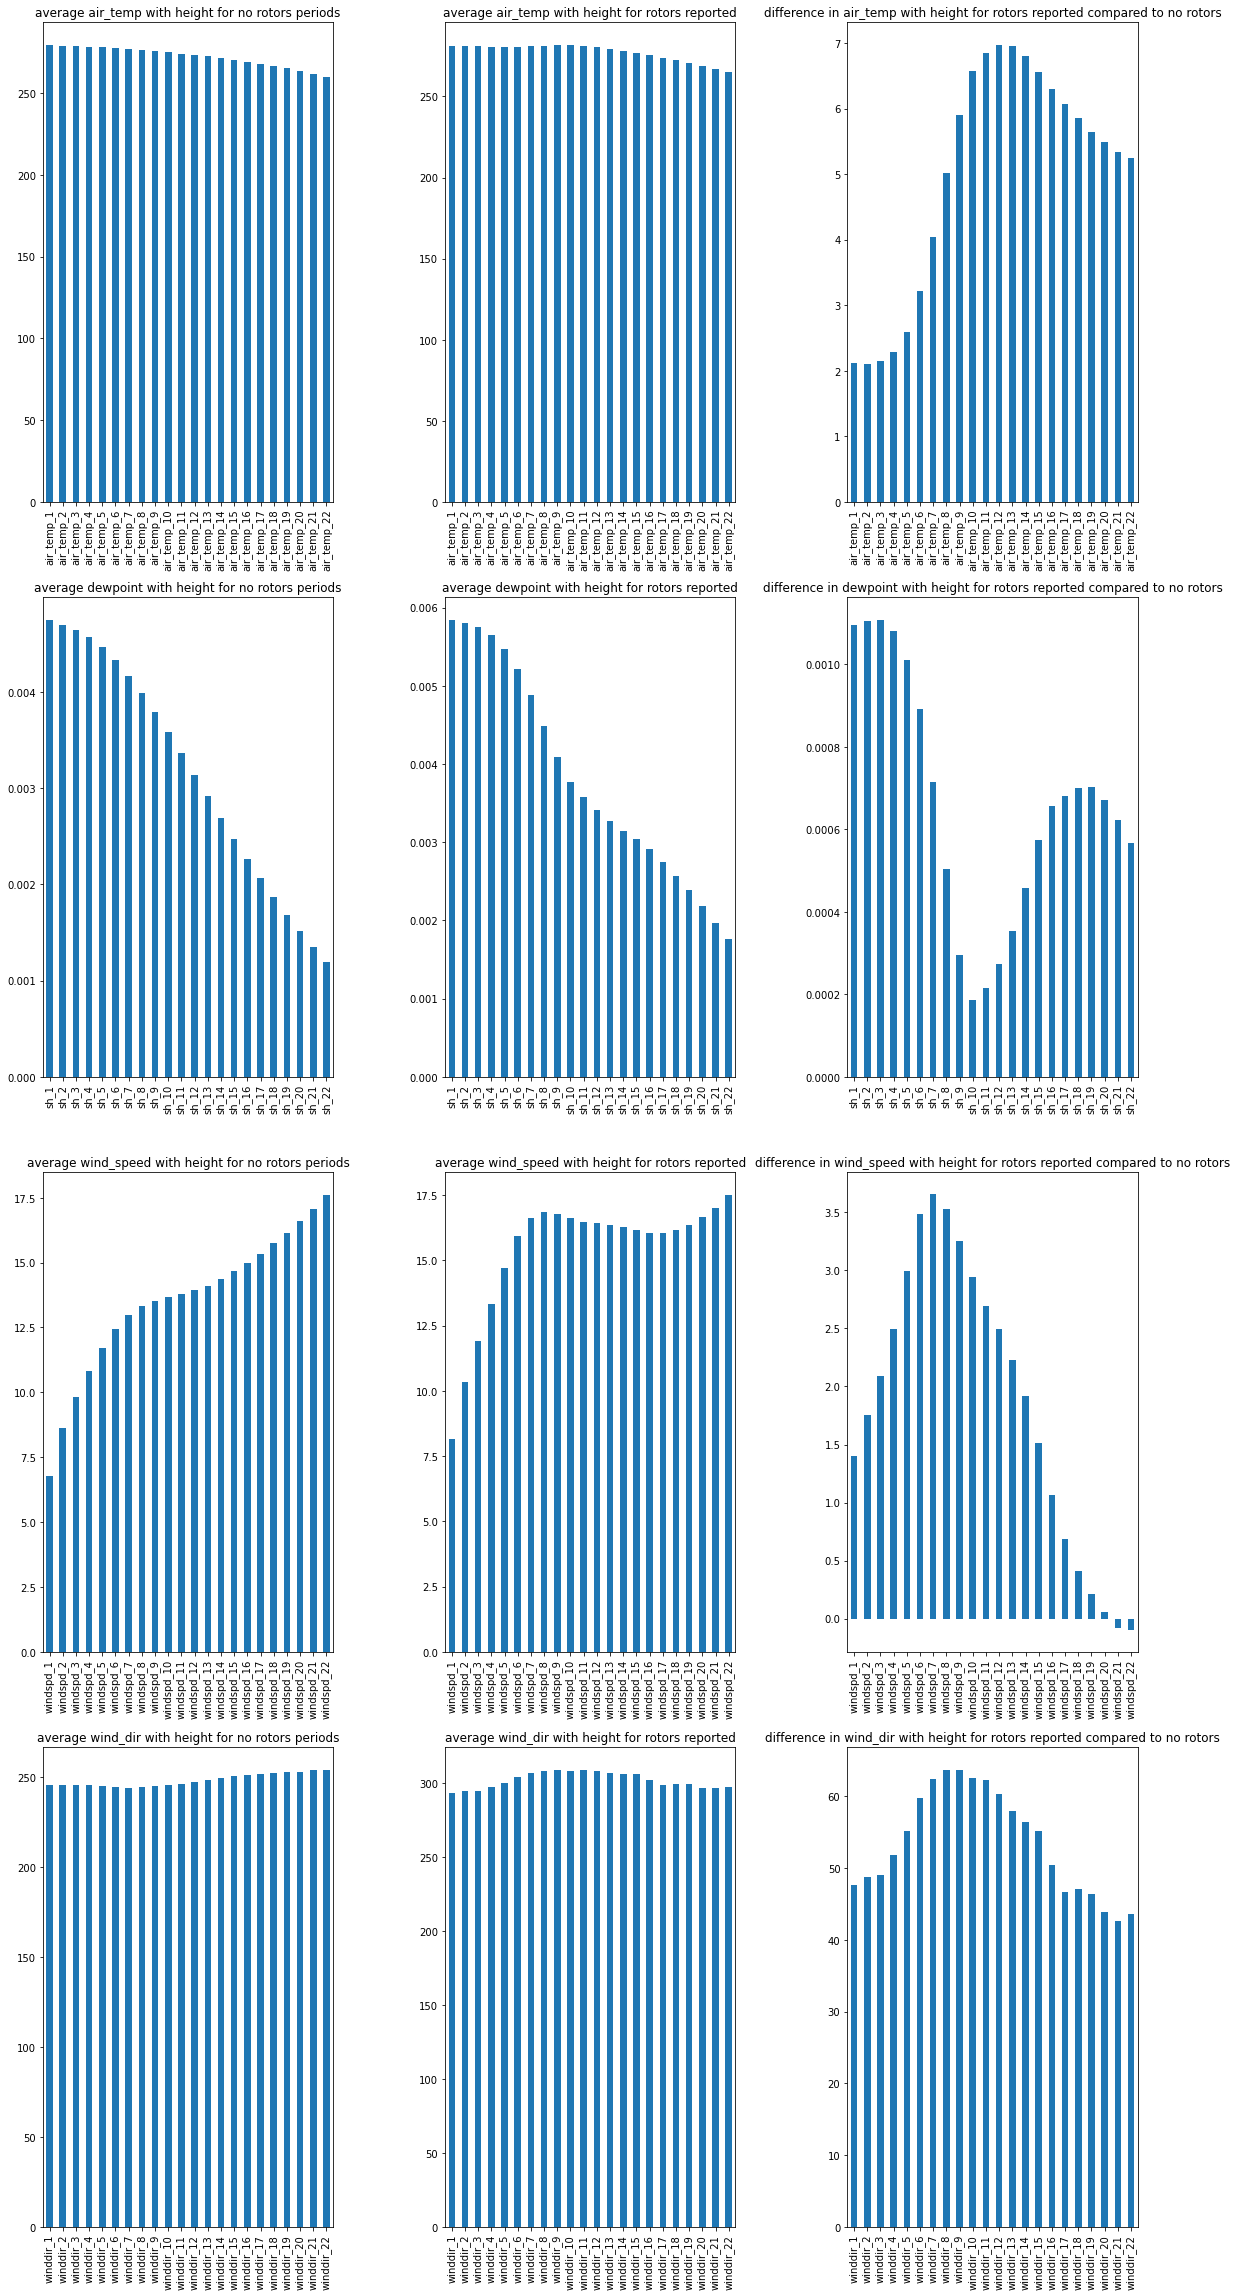

In [25]:
# How many keys are there in the dictionary
num_vars = len(features_dict.keys())

num_plots = 3

# plots of mean values for no rotors, rotors and the difference

fig1 = matplotlib.pyplot.figure(figsize=(16,8*num_vars))
for ix1, (feature_name, fl1) in enumerate(features_dict.items()):
    ax1 = fig1.add_subplot(num_vars,num_plots,ix1*num_plots+1,
        title=f'average {feature_name} with height for no rotors periods')
    no_rotors_df[fl1].mean().plot.bar(ax=ax1)
    
    ax1 = fig1.add_subplot(num_vars,num_plots,ix1*num_plots+2, 
        title=f'average {feature_name} with height for rotors reported')
    rotors_present_df[fl1].mean().plot.bar(ax=ax1)
    
    ax1 = fig1.add_subplot(num_vars,num_plots,ix1*num_plots+3, 
        title=f'difference in {feature_name} with height for rotors reported compared to no rotors')
    (rotors_present_df[fl1].mean() - no_rotors_df[fl1].mean() ).plot.bar(ax=ax1)
matplotlib.pyplot.tight_layout(w_pad=7)

Next up we want to explore the relationship between the forecast data and the observations.

In [30]:
falklands_df.columns



Index(['DTG', 'air_temp_obs', 'dewpoint_obs', 'wind_direction_obs',
       'wind_speed_obs', 'wind_gust_obs', 'air_temp_1', 'air_temp_2',
       'air_temp_3', 'air_temp_4', 'air_temp_5', 'air_temp_6', 'air_temp_7',
       'air_temp_8', 'air_temp_9', 'air_temp_10', 'air_temp_11', 'air_temp_12',
       'air_temp_13', 'air_temp_14', 'air_temp_15', 'air_temp_16',
       'air_temp_17', 'air_temp_18', 'air_temp_19', 'air_temp_20',
       'air_temp_21', 'air_temp_22', 'sh_1', 'sh_2', 'sh_3', 'sh_4', 'sh_5',
       'sh_6', 'sh_7', 'sh_8', 'sh_9', 'sh_10', 'sh_11', 'sh_12', 'sh_13',
       'sh_14', 'sh_15', 'sh_16', 'sh_17', 'sh_18', 'sh_19', 'sh_20', 'sh_21',
       'sh_22', 'winddir_1', 'windspd_1', 'winddir_2', 'windspd_2',
       'winddir_3', 'windspd_3', 'winddir_4', 'windspd_4', 'winddir_5',
       'windspd_5', 'winddir_6', 'windspd_6', 'winddir_7', 'windspd_7',
       'winddir_8', 'windspd_8', 'winddir_9', 'windspd_9', 'winddir_10',
       'windspd_10', 'winddir_11', 'windspd_11', 'windd

### Additional Exercises
* Try to plot the histogram of model data at the surface level (height level index 1)
* Plot the model surface data grouped by different times of day.

### Comparison with human performance

This dataset also has some data containing the prediction made by human OpMets ahead of time. This is the baseline that we would need to match or improve upon for the algorithm to be useful.

In [26]:
opmet_results_path = falklands_data_dir / 'rotors_opmet_performance_2016_2021.csv'
opmet_results_path

PosixPath('/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge/Rotors/rotors_opmet_performance_2016_2021.csv')

In [27]:
opmet_predictions_df = pandas.read_csv(opmet_results_path)

In [28]:
# set missing values to zero
opmet_predictions_df.loc[opmet_predictions_df[opmet_predictions_df.observation.isna()].index,'observation'] = 0.0
opmet_predictions_df.loc[opmet_predictions_df[opmet_predictions_df['opmet_forecast'].isna()].index,'opmet_forecast'] = 0.0

# Create datatime variables
opmet_predictions_df['DTG'] = pandas.to_datetime(opmet_predictions_df['DTG'])


In [29]:
opmet_predictions_df

,DTG,observation,opmet_forecast,Hit,False Positive,True Negative,Miss
0,2016-09-19 00:00:00,0.0,0.0,False,False,True,False
1,2016-09-19 01:00:00,0.0,0.0,False,False,True,False
2,2016-09-19 02:00:00,0.0,0.0,False,False,True,False
3,2016-09-19 03:00:00,0.0,0.0,False,False,True,False
4,2016-09-19 04:00:00,0.0,0.0,False,False,True,False
...,...,...,...,...,...,...,...
38971,2021-02-28 19:00:00,0.0,1.0,False,True,False,False
38972,2021-02-28 20:00:00,0.0,1.0,False,True,False,False
38973,2021-02-28 21:00:00,0.0,0.0,False,False,True,False
38974,2021-02-28 22:00:00,0.0,0.0,False,False,True,False


In [30]:
opmet_predictions_df['observation'].value_counts()

0.0    37726
1.0     1250
Name: observation, dtype: int64

In [31]:
opmet_predictions_df['opmet_forecast'].value_counts()

0.0     33551
1.0      5424
11.0        1
Name: opmet_forecast, dtype: int64

In [32]:
# create binary vector for TP, TN, FP and FN
opmet_predictions_df['truePositive'] = ((opmet_predictions_df['observation'] == 1 ) & (opmet_predictions_df['opmet_forecast'] ==1))
opmet_predictions_df['falsePositive']  = ((opmet_predictions_df['observation'] == 0 ) & (opmet_predictions_df['opmet_forecast'] ==1))
opmet_predictions_df['trueNegative'] = ((opmet_predictions_df['observation'] == 0 ) & (opmet_predictions_df['opmet_forecast'] ==0))
opmet_predictions_df['falseNegative']  = ((opmet_predictions_df['observation'] == 1 ) & (opmet_predictions_df['opmet_forecast'] ==0))

In [35]:
# create vector contains words "trueNegative", 'falseNegative' etc
opmet_predictions_df['result_category'] = 'trueNegative'

opmet_predictions_df.loc[opmet_predictions_df[opmet_predictions_df['falseNegative']==True].index,'result_category'] = 'falseNegative'
opmet_predictions_df.loc[opmet_predictions_df[opmet_predictions_df['falsePositive']==True].index,'result_category'] = 'falsePositive'
opmet_predictions_df.loc[opmet_predictions_df[opmet_predictions_df['truePositive']==True].index,'result_category'] = 'truePositive'

opmet_predictions_df['result_category'].value_counts()

trueNegative     33476
falsePositive     4250
truePositive      1174
falseNegative       76
Name: result_category, dtype: int64

In [36]:
# convert 0/1 to 'no rotors' and 'rotor present'
opmet_predictions_df['observation'].apply(lambda x: {0.0: 'no rotors',1.0:'rotor present'}[x]).value_counts()

no rotors        37726
rotor present     1250
Name: observation, dtype: int64

/var/tmp/ipykernel_56830/1416574973.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


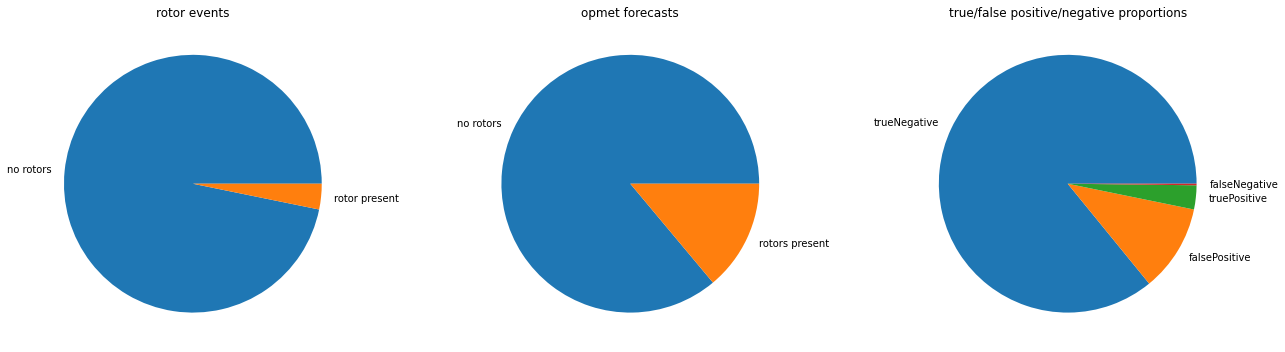

In [39]:
# Pie charts for rotor/ no rotor events, opmet forecasts for rotors
# and classification statistics

fig1 = matplotlib.pyplot.figure('comparisonn of hits/isses/etc.', figsize=((18,6)))

ax1 = fig1.add_subplot(1,3,1,title='rotor events')
opmet_predictions_df['observation'].apply(lambda x: {0.0: 'no rotors',
        1.0:'rotor present'}[x]).value_counts().plot.pie(ax=ax1, ylabel='')

ax1 = fig1.add_subplot(1,3,2,title='opmet forecasts')
opmet_predictions_df['opmet_forecast'][opmet_predictions_df['opmet_forecast'] < 
   2].apply(lambda x: {0.0: 'no rotors', 1.0 : 'rotors present'
                      }[x]).value_counts().plot.pie(ax=ax1, ylabel='')

ax1 = fig1.add_subplot(1,3,3,title='true/false positive/negative proportions')
opmet_predictions_df['result_category'].value_counts().plot.pie(ax=ax1, ylabel='')
matplotlib.pyplot.tight_layout(w_pad=4)

fig1.show()

Exploration of this data shows us that OpMets routinely overpredict rotor events (large values of false positives). This is what you would expect, as the cost of missing a rotor event (false negative) is much higher than the cost of predicting an event and it not happening (false positive). **So the challenge for our ML algorithm is to eliminate false negatives while maintaining an acceptably low false positive rate** so as to maintain trust in forecast output.

## Load and explore gridded model data - ERA5

In [40]:
try:
    era5_root = os.environ['ERA5_DATA_ROOT']
except KeyError:
    era5_root = '/project/informatics_lab/data_science_cop/era5/'
era5_data_dir = pathlib.Path(era5_root) 
print(era5_data_dir)

/project/informatics_lab/data_science_cop/era5


In [41]:
nc_files = sorted([str(i1) for i1 in era5_data_dir.iterdir() if '.nc' in str(i1) and 'air_pressure' in str(i1)])
nc_files

['/project/informatics_lab/data_science_cop/era5/air_pressure_mean_sea_level_2017_01.nc',
 '/project/informatics_lab/data_science_cop/era5/air_pressure_mean_sea_level_2017_02.nc',
 '/project/informatics_lab/data_science_cop/era5/air_pressure_mean_sea_level_2017_03.nc',
 '/project/informatics_lab/data_science_cop/era5/air_pressure_mean_sea_level_2017_04.nc',
 '/project/informatics_lab/data_science_cop/era5/air_pressure_mean_sea_level_2017_05.nc',
 '/project/informatics_lab/data_science_cop/era5/air_pressure_mean_sea_level_2017_06.nc',
 '/project/informatics_lab/data_science_cop/era5/air_pressure_mean_sea_level_2017_07.nc',
 '/project/informatics_lab/data_science_cop/era5/air_pressure_mean_sea_level_2017_08.nc',
 '/project/informatics_lab/data_science_cop/era5/air_pressure_mean_sea_level_2017_09.nc',
 '/project/informatics_lab/data_science_cop/era5/air_pressure_mean_sea_level_2017_10.nc',
 '/project/informatics_lab/data_science_cop/era5/air_pressure_mean_sea_level_2017_11.nc',
 '/project

In [42]:
era5_cubeList = iris.load(nc_files)
iris.util.equalise_attributes(era5_cubeList)
mslp_era5_cube = iris.cube.CubeList.concatenate_cube(era5_cubeList)

In [43]:
mslp_era5_cube

Air Pressure At Mean Sea Level (Pa),time,latitude,longitude
Shape,26280,721,1440
Dimension coordinates,,,
time,x,-,-
latitude,-,x,-
longitude,-,-,x
Attributes,,,institution ECMWFnameCDM Mean_sea_level_pressure_surfacenameECMWF Mean sea level pressureproduct_type analysisshortNameECMWF mslsource Reanalysis


In [44]:
uk_na_bounds = {'latitude': (40,65), 'longitude': (-10,10)}

In [45]:
mslp_era5_uk_cube = mslp_era5_cube.intersection(latitude=uk_na_bounds['latitude'], 
                                                longitude=uk_na_bounds['longitude'])
mslp_era5_uk_cube

Air Pressure At Mean Sea Level (Pa),time,latitude,longitude
Shape,26280,101,81
Dimension coordinates,,,
time,x,-,-
latitude,-,x,-
longitude,-,-,x
Attributes,,,institution ECMWFnameCDM Mean_sea_level_pressure_surfacenameECMWF Mean sea level pressureproduct_type analysisshortNameECMWF mslsource Reanalysis


In [46]:
iris.iris.coord_categorisation.add_season_number(mslp_era5_uk_cube,'time')

In [47]:
functools.reduce(lambda x,y: x*y, mslp_era5_cube.shape), functools.reduce(lambda x,y: x*y, mslp_era5_uk_cube.shape)

#TODO pretty print and explanation of why.

(27284947200, 214996680)

In [48]:
mslp_era5_uk_cube

Air Pressure At Mean Sea Level (Pa),time,latitude,longitude
Shape,26280,101,81
Dimension coordinates,,,
time,x,-,-
latitude,-,x,-
longitude,-,-,x
Auxiliary coordinates,,,
season_number,x,-,-
Attributes,,,institution ECMWFnameCDM Mean_sea_level_pressure_surfacenameECMWF Mean sea level pressureproduct_type analysisshortNameECMWF mslsource Reanalysis


In [49]:
min(mslp_era5_uk_cube.coord('latitude').points), max(mslp_era5_uk_cube.coord('latitude').points)

(40.0, 65.0)

In [50]:
min(mslp_era5_uk_cube.coord('longitude').points), max(mslp_era5_uk_cube.coord('longitude').points)

(-10.0, 10.0)

In [51]:
mslp_uk_seasonal_mean = mslp_era5_uk_cube.aggregated_by(['season_number'],iris.analysis.MEAN)
mslp_uk_seasonal_mean

<iris 'Cube' of air_pressure_at_mean_sea_level / (Pa) (-- : 4; latitude: 101; longitude: 81)>

Now we can plot the seasonal averages as a way of exploring the data.
*NOTE* This cell will take a while to execute. This is because up until now none of the calculations described will actually have been executed, due to the *lazy loading* paradigm employed in Iris. Only at the point when the data is needed (in our case to actually create the plots), are the compute operations actually triggered. So what is taking time is the subsetting and aggregation of the data, rather than only the actual plotting operations.

In [52]:
%%time
mslp_uk_seasonal_mean.data

CPU times: user 15min 17s, sys: 2min 41s, total: 17min 59s
Wall time: 17min 50s


masked_array(
  data=[[[100171.664, 100177.51 , 100183.39 , ..., 100494.01 ,
          100503.13 , 100512.21 ],
         [100173.05 , 100179.48 , 100186.16 , ..., 100512.85 ,
          100521.86 , 100530.516],
         [100176.336, 100182.164, 100187.99 , ..., 100530.87 ,
          100538.695, 100546.51 ],
         ...,
         [102283.5  , 102281.195, 102281.26 , ..., 101754.805,
          101718.875, 101711.2  ],
         [102290.055, 102286.984, 102285.984, ..., 101769.375,
          101718.766, 101716.75 ],
         [102295.23 , 102292.336, 102290.13 , ..., 101775.586,
          101718.02 , 101722.27 ]],

        [[101111.58 , 101116.48 , 101121.38 , ..., 101235.36 ,
          101236.83 , 101238.28 ],
         [101104.28 , 101109.64 , 101115.16 , ..., 101240.87 ,
          101242.73 , 101244.58 ],
         [101097.75 , 101102.7  , 101107.68 , ..., 101245.586,
          101247.5  , 101249.39 ],
         ...,
         [101664.13 , 101656.4  , 101651.36 , ..., 101444.68 ,
          1

In [ ]:
fig1 = matplotlib.pyplot.figure(figsize=(16,16))
for ix1 in range(mslp_uk_seasonal_mean.shape[0]):
    ax1 = fig1.add_subplot(2,2,ix1+1,projection=cartopy.crs.PlateCarree())
    iris.quickplot.contourf(mslp_uk_seasonal_mean[ix1],axes=ax1)
    ax1.coastlines()

### Addtional execises
* try to cut out a different area, e.g. Australia 10-43S, 113-153E and do plots for that area.
* Try and find the average for a month and find the anomaly for that that month.

## Next Steps

There are further example notebooks looking at loading and exploring data in Python in the following locations:
* [Introduction to Data Analysis in Python](https://github.com/informatics-lab/intro_python_data_analysis/)
* [Pangeo Lectures](https://github.com/informatics-lab/PangeoLectures)
* [Using Climate Data](https://github.com/Informatics-lab/UsingClimateData)


## Dataset Info

### Falklands Rotors Challenge Dataset
Crown Copyright 2021 - This dataset was created by Met Office Chief Operational Meteorologist Steve Ramsdale from Met Office forecast and observation data.
* Model Data - Met Office Global 10km resolution model
* Observations - made by meteorologists at Mount Pleasant airfield in the Falkland Islands.

### ERA5
ERA5 is Reanalysis data created by ECMWF. Reanalysis combines observations from many sources. by assimilating these into a forecast model (ECMWF's IFS in this case), to provide a consistent physically valid gridded dataset that is a close to observations as possible
https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5



## References

The format of this notebook is based on the [template for tutorial notebooks](https://github.com/geo-yrao/notebook-dev/blob/main/templates/NCAI_Training_Notebook_template%20-%20Distribution%20Copy.ipynb) developed by NOAA, available on GitHub.